In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 12 15:02:53 2025

@author: yuhanyao
"""

import os
import time
import numpy as np
import astropy.io.ascii as asci
from scipy.stats import poisson

from scipy.integrate import simpson
from astropy.io import fits
import astropy.constants as const
import astropy.constants as const

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

from plot_roman_lightcurve import cc_bol

fs= 12
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms


In [2]:
lamb_obs_um = 1 
golden_ratio = 1.618

fig_width = 6
fig_height = fig_width/golden_ratio

In [3]:
def compute_universe_size():
    zs = np.array([0.1, 0.5, 1,2,3,6,10])
    Vs_Gpc3 = np.zeros(len(zs))
    for i in range(len(zs)):
        z = zs[i]
        D_Mpc = cosmo.comoving_distance([z])[0].value 
        V_Mpc3 = 4*np.pi / 3 * D_Mpc**3
        Vs_Gpc3[i] = V_Mpc3 / 1e+9
    
    plt.plot(zs, Vs_Gpc3, "o")
    plt.semilogy()
    plt.semilogx()
    plt.xlabel("z")
    plt.ylabel("Comoving volume (Gpc^3)")
    
    
def get_gmf_z(z = 4, lgxs = np.linspace(7, 11.5)):
    """
    get galaxy stellar mass function 
    """
    xs = 10**lgxs
    
    if z==0:
        # Wright+2017
        lgM0 = 10.84
        lgphi1 = -4.30
        alpha1 = -0.
        lgphi2 = -3.94
        alpha2 = -1.79
        M0 = 10**lgM0
        phi1 = 10**lgphi1
        phi2 = 10**lgphi2
        phi = np.log(10) * np.exp(-(xs/M0)) * (xs/M0) * (phi1 * (xs/M0)**alpha1 + phi2 * (xs/M0)**alpha2)
        
    elif z>=4:
        # Song+2016
        if z<4.5:
            lgM0 = 10.50
            alpha = -1.55
            phi0 = 25.68e-5
        elif z<5.5:
            lgM0 = 10.97
            alpha = -1.70
            phi0 = 5.16e-5
        elif z<6.5:
            lgM0 = 10.72
            alpha = -1.91
            phi0 = 1.35e-5
        elif z<7.5:
            lgM0 = 10.78
            alpha = -1.95
            phi0 = 0.53e-5
        else:
            lgM0 = 10.72
            alpha = -2.25
            phi0 = 0.035e-5
        M0 = 10**lgM0
            
        phi = phi0 * (xs/M0) * (xs/M0)**alpha * np.exp(-(xs/M0))
    else:
        # Mcleod+2021
        if z<=0.75:#z==0.5:
            lgM0 = 10.80
            lgphi1 = -2.77
            alpha1 = -0.61
            lgphi2 = -3.26
            alpha2 = -1.52
        elif z<=1.25:#z==1.0:
            lgM0 = 10.72
            lgphi1 = -2.80
            alpha1 = -0.46
            lgphi2 = -3.26
            alpha2 = -1.53
        elif z<=1.75:#z==1.5:
            lgM0 = 10.72
            lgphi1 = -2.94
            alpha1 = -0.55
            lgphi2 = -3.54
            alpha2 = -1.65
        elif z<=2.25:#z==2.0:
            lgM0 = 10.77
            lgphi1 = -3.18
            alpha1 = -0.68
            lgphi2 = -3.84
            alpha2 = -1.73
        elif z<=2.88:#z==2.5:
            lgM0 = 10.77
            lgphi1 = -3.39
            alpha1 = -0.62
            lgphi2 = -3.78
            alpha2 = -1.74
        else:# z==3.25:
            lgM0 = 10.84
            lgphi1 = -4.30
            alpha1 = -0.
            lgphi2 = -3.94
            alpha2 = -1.79
        M0 = 10**lgM0
        phi1 = 10**lgphi1
        phi2 = 10**lgphi2
        phi = np.log(10) * np.exp(-(xs/M0)) * (xs/M0) * (phi1 * (xs/M0)**alpha1 + phi2 * (xs/M0)**alpha2)
        
    return phi

In [4]:
def planck_nu(T, Rbb, nu):
    '''
    T in the unit of K
    Rbb in the unit of Rsun
    lamb in the unit of Hz
    '''
    x = const.h.cgs.value * nu / (const.k_B.cgs.value * T)
    x = np.array(x)
    # erg/cm2/Ang/sr/s/Hz
    Bnu = (2. * const.h.cgs.value * nu**3 ) /  ( const.c.cgs.value**2 ) / (np.exp(x) - 1. ) 
    spec = Bnu
    # convert back to ANGSTROM   
    Rbb *= const.R_sun.cgs.value
    spec1 = spec * (4. * np.pi * Rbb**2) * np.pi # erg/Hz/s
    # spec1 *= 1./ (4*np.pi*D**2) to correct for distance
    return spec1


def plot_gmf_z():
    lgxs = np.linspace(7, 12)
    zs = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.25, 4, 5,6,7,8])
    
    plt.figure()
    ax = plt.subplot(111)
    for i in range(len(zs)):
        z = zs[i]
        phi = get_gmf_z(z, lgxs)
        
        ax.plot(lgxs, phi, label = "z=%.2f"%z)
        
        mask = (lgxs >= 9)
        x_selected = lgxs[mask]
        y_selected = phi[mask]
        
        # Perform numerical integration using Simpson's rule
        n = simpson(y_selected, x=x_selected)
        print (z, n)
    ax.semilogy()
    ax.legend(ncol = 2)
    ax.set_xlim(8, 11.5)
    ax.set_ylim(1e-7, 1e-1)
    ax.set_xlabel("log(M/Msun)")
    ax.set_ylabel("# / dex / Mpc^3")
    
    
def age_to_redshift(age_Gyr):
    """
    Convert the age of the universe (in Gyr) to redshift using the Planck18 cosmology.
    
    Parameters:
    age_Gyr (float): Age of the universe in gigayears (Gyr)
    
    Returns:
    float: Corresponding redshift (z)
    """
    from scipy.optimize import brentq
    
    # Function to find root (i.e., where age(z) matches the input age)
    def age_difference(z):
        return cosmo.age(z).value - age_Gyr

    # Solve for redshift, assuming z is in the range (0, 20)
    z_sol = brentq(age_difference, 0, 20)
    return z_sol

In [5]:
# age_univs = np.array([1, 2, 3,4,5, 6,7,8,9,10])
# age_univs_bounds = np.array([1, 2, 3,4,5, 6,7,8,9,10,11])-0.5
# _zs = np.array([age_to_redshift(x) for x in age_univs])
# _zs_bounds = np.array([age_to_redshift(x) for x in age_univs_bounds])
# zs = _zs[::-1]
# zs_bounds =  _zs_bounds[::-1]

# zs = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.25, 4, 5,6,7,8])
# zs_bounds = np.array([0.3, 0.75, 1.25, 1.75, 2.25, 2.8, 3.7, 4.5, 5.5, 6.5, 7.5, 8.5])
# zs_left = zs_bounds[:-1]
# zs_right = zs_bounds[1:]

# zs, zs_bounds
n_step = 19
zs = np.linspace(0.0, 6., n_step)[1:]
step = zs[-1] - zs[-2]
zs -= 0.5*step

zs_left = zs - 0.5 * step
zs_left[0] = 0.
zs_right = zs + 0.5 * step

filename_in = "./data/yao2023_tde.dat"

lamb_obs_cm = lamb_obs_um/1e+4
nu_obs = const.c.cgs.value / lamb_obs_cm


tb = asci.read(filename_in)

verbose = False
if verbose:
    plt.figure()
    plt.plot(tb["mass_SS"], tb["lgLbb"], "o")
    plt.plot([10, 10], [43, 45.5], "--")
    plt.plot([10.5, 10.5], [43, 45.5], ":")
    plt.plot([11, 11], [43, 45.5], "-.")
    
grp = np.zeros(len(tb))
ix1 = tb["mass_SS"]<10
ix2 = (tb["mass_SS"]>=10)&(tb["mass_SS"]<10.5)
grp[ix1] = 1
grp[ix2] = 2
grp[(~ix1)&(~ix2)] = 3

D_pcs = cosmo.luminosity_distance([zs])[0].value * 1e+6 
D_cms = D_pcs * const.pc.cgs.value
    
mpeaks = np.zeros((len(tb), len(zs)))

for i in range(len(tb)):
    lgTbb = tb["lgTbb"][i]
    lgLbb = tb["lgLbb"][i]
    
    for j in range(len(zs)):
        z = zs[j]
        
        nu_rest = nu_obs * (1+z)
        nuLnu_rest = 10**lgLbb * cc_bol(10**lgTbb, nu=nu_rest)
        Lnu_obs = nuLnu_rest / nu_obs
        
        mpeaks[i, j] = -2.5 * np.log10(Lnu_obs / (4 * np.pi* D_cms[j]**2)/3631e-23)
    
# This is not the most accurate way to do this, but is order of magnitude correct
r12_avg = 3e-5 # rate per galaxy per yr from 10^9 to 10^10.5 Msun
r3_avg = 1e-6 # rate per galaxy per yr from 10^10.5 to 10^11 Msun


n1s = np.zeros(len(zs))
n2s = np.zeros(len(zs))
n3s = np.zeros(len(zs))
for i in range(len(zs)):
    myz = zs[i]

    lgxs = np.linspace(8, 12)
    phi = get_gmf_z(myz, lgxs)
    
    mask1 = (lgxs >= 9)&(lgxs < 10)
    mask2 = (lgxs >= 10)&(lgxs < 10.5)
    mask3 = (lgxs >= 10.5)&(lgxs < 11)
    
    # Perform numerical integration using Simpson's rule
    # number density of galaxies in three mass ranges
    n1s[i] = simpson(phi[mask1], x=lgxs[mask1]) 
    n2s[i] = simpson(phi[mask2], x=lgxs[mask2]) 
    n3s[i] = simpson(phi[mask3], x=lgxs[mask3]) 


mpeak_lims = np.array([25, 26.3, 27])
colors = ["gray", "tab:red", "tab:green"]
linstyles = ["--", "-", ":"]

# Roman rate (per-yr) per each redshift bin, with difference peak magnitude!
Ns = np.zeros((len(mpeak_lims), len(zs))) 

frac_area = 49 / (4*np.pi/np.pi**2*180**2)

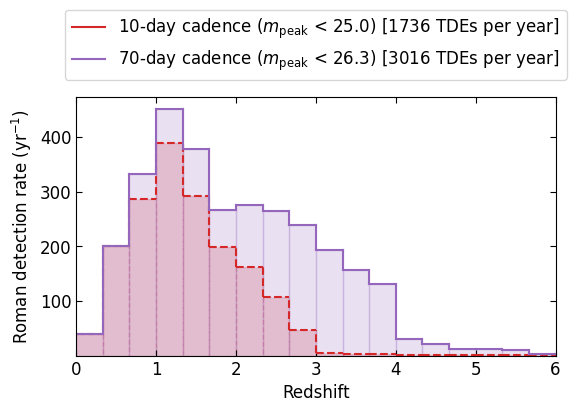

In [6]:
plt.figure(figsize = (fig_width, fig_height*1.2))
ax = plt.subplot(111)

lines = []

for i in range(len(mpeak_lims)):
    mpeak_lim = mpeak_lims[i]
    if mpeak_lim==27:
        continue
    mycolor = f"C{i+3}"
    myls = linstyles[i]
    # mylabel = r"$m_{\rm peak}<%d$"%mpeak_lim
    mylabel = fr"{10 * [1, 7][i]}-day cadence " + r"($m_{\rm peak}$" + f" < {mpeak_lim})"
    # if mpeak_lim==25:
    #     mylabel = "without proposal"
    # elif mpeak_lim==26:
    #     mylabel = "with proposal"
    # print ("")
    # print (mylabel)
    for j in range(len(zs)):
        myz = zs[j]
        zleft = zs_left[j]
        zright = zs_right[j]
        # comoving volume 
        D_L_Mpc = cosmo.luminosity_distance(myz).value
        D_L_cm = D_L_Mpc * const.pc.cgs.value * 1e+6
        
        D_cd_Mpc_left = cosmo.comoving_distance(zleft).value
        D_cd_Mpc_right = cosmo.comoving_distance(zright).value
        V_c_Mpc3 = 4*np.pi/3 * (D_cd_Mpc_right**3 - D_cd_Mpc_left**3)
        
        frac_det1 = np.sum(mpeaks[grp==1,j]<mpeak_lim)
        frac_det2 = np.sum(mpeaks[grp==2,j]<mpeak_lim)
        frac_det3 = np.sum(mpeaks[grp==3,j]<mpeak_lim)
        
        N1 = n1s[j] * V_c_Mpc3 * r12_avg * frac_area * frac_det1
        N2 = n2s[j] * V_c_Mpc3 * r12_avg * frac_area * frac_det2
        N3 = n3s[j] * V_c_Mpc3 * r3_avg * frac_area * frac_det3
        
        Ns[i, j] = N1 + N2 + N3

        # if j==0:
        ax.plot([zleft, zright], [Ns[i, j], Ns[i, j]], color = mycolor, linestyle = myls)
            # ax.fill_between([zleft, zright], [0, 0], [Ns[i, j], Ns[i, j]], color = mycolor, linestyle = myls, alpha=0.2)
        # else:
        #     ax.plot([zleft, zright], [Ns[i, j], Ns[i, j]], color = mycolor, linestyle = myls)
        if j > 0:
            ax.plot([zleft, zs_right[j-1]], [Ns[i, j], Ns[i, j-1]], color = mycolor, linestyle = myls)
        ax.fill_between([zleft, zright], [0, 0], [Ns[i, j], Ns[i, j]], color = mycolor, linestyle = myls, alpha=0.2)
        # print (myz, N1, N2, N3)

    # mylabel += r" [$N_{\rm TDE}$" + f" = {int(Ns[i].sum())} TDEs per year]"
    mylabel += f" [{int(Ns[i].sum())} TDEs per year]"


    lines.append(Line2D([0], [0], label=mylabel, color=mycolor))


# add manual symbols to auto legend
handles, labels = ax.get_legend_handles_labels()
handles.extend(lines)
ax.legend(bbox_to_anchor=(0.5,1.2), ncols=1, handles=handles, loc='center')
        
# ax.semilogy()
ax.set_xlabel("Redshift")
ax.set_ylabel("Roman detection rate ("+r"$\rm yr^{-1})$")
ymin, ymax = ax.get_ylim()
ymin = max(ymin, 0.2)
ax.set_ylim(ymin, ymax)
ax.tick_params(which = 'major', length = 4, top=True, direction = "in", right = True)
ax.tick_params(which = 'minor', length = 2, top=True, direction = "in", right = True)
ax.set_xlim(left=zs_left[0], right=zs_right[-1])
plt.tight_layout()
plt.savefig("./figs/nuclear_tde_rate.pdf", dpi=300., bbox_inches='tight')

In [7]:
mask = zs > 3.0

print(Ns[0][mask].sum(), Ns[1][mask].sum())
Ns[1][mask].sum()/Ns[0][mask].sum()

14.080390446199255 569.5806537813339


np.float64(40.4520496755885)

In [8]:
zs

array([0.16666667, 0.5       , 0.83333333, 1.16666667, 1.5       ,
       1.83333333, 2.16666667, 2.5       , 2.83333333, 3.16666667,
       3.5       , 3.83333333, 4.16666667, 4.5       , 4.83333333,
       5.16666667, 5.5       , 5.83333333])

In [9]:
zs_left
zs_right

array([0.33333333, 0.66666667, 1.        , 1.33333333, 1.66666667,
       2.        , 2.33333333, 2.66666667, 3.        , 3.33333333,
       3.66666667, 4.        , 4.33333333, 4.66666667, 5.        ,
       5.33333333, 5.66666667, 6.        ])

In [10]:
27./17.

1.588235294117647

In [11]:
zs_right

array([0.33333333, 0.66666667, 1.        , 1.33333333, 1.66666667,
       2.        , 2.33333333, 2.66666667, 3.        , 3.33333333,
       3.66666667, 4.        , 4.33333333, 4.66666667, 5.        ,
       5.33333333, 5.66666667, 6.        ])

In [12]:
zs_left

array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ,
       3.33333333, 3.66666667, 4.        , 4.33333333, 4.66666667,
       5.        , 5.33333333, 5.66666667])

In [13]:
zs

array([0.16666667, 0.5       , 0.83333333, 1.16666667, 1.5       ,
       1.83333333, 2.16666667, 2.5       , 2.83333333, 3.16666667,
       3.5       , 3.83333333, 4.16666667, 4.5       , 4.83333333,
       5.16666667, 5.5       , 5.83333333])